In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

from wongutils.grmhd.athenak import AthenaKSnapshot

In [2]:
fname = 'torus.mhd_w_bcc.01000.bin'
snapshot = AthenaKSnapshot(fname)

100%|██████████| 456/456 [00:22<00:00, 20.05it/s]


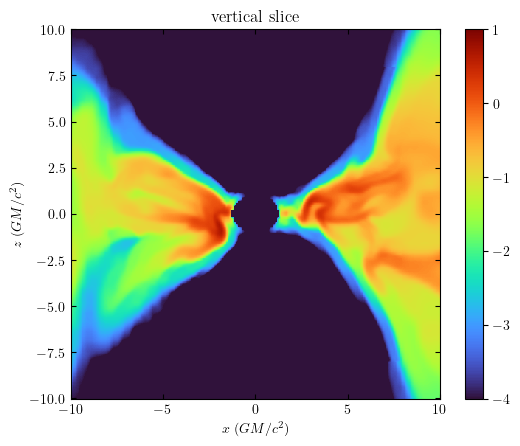

In [3]:
plim = 10
res = 501

xs = np.linspace(-plim, plim, res)
ys = np.zeros((1))
zs = np.linspace(-plim, plim, res)
X, Y, Z = np.meshgrid(xs, ys, zs, indexing='ij')

prims = snapshot.get_primitives_at(Y, X, Z)
# 8 -> density, internal energy, vx, vy, vz, bx, by, bz

ax1 = plt.subplot(1, 1, 1)

im1 = ax1.pcolormesh(X[:, 0, :], Z[:, 0, :], np.log10(prims[:, 0, :, 0]), vmin=-4, vmax=1, cmap='turbo')
plt.colorbar(im1)

ax1.set_aspect('equal')
ax1.tick_params(direction='in', which='both', top=True, right=True, color='k')
ax1.set_xlabel(r'$x\ (GM/c^2)$')
ax1.set_ylabel(r'$z\ (GM/c^2)$')
ax1.set_title('vertical slice') ;

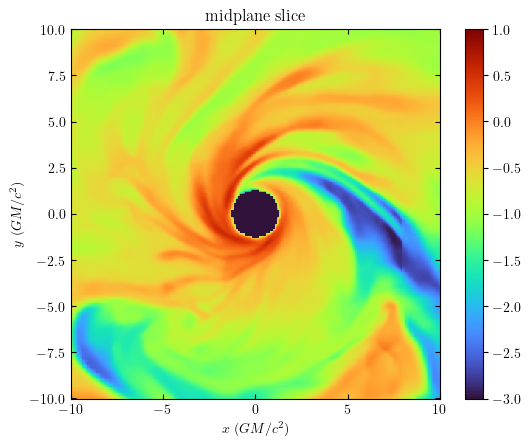

In [4]:
plim = 10
res = 501

xs = np.linspace(-plim, plim, res)
ys = np.linspace(-plim, plim, res)
zs = np.zeros((1))
X, Y, Z = np.meshgrid(xs, ys, zs, indexing='ij')

prims = snapshot.get_primitives_at(X, Y, Z)

ax1 = plt.subplot(1, 1, 1)

im1 = ax1.pcolormesh(X[:, :, 0], Y[:, :, 0], np.log10(prims[:, :, 0, 0]), vmin=-3, vmax=1, cmap='turbo')
plt.colorbar(im1)

ax1.set_aspect('equal')
ax1.tick_params(direction='in', which='both', top=True, right=True, color='k')
ax1.set_xlabel(r'$x\ (GM/c^2)$')
ax1.set_ylabel(r'$y\ (GM/c^2)$')
ax1.set_title('midplane slice') ;